# Plan

#### Pre-starting

How much time do I have?
- 6 blocks of time

What all do I need to complete?

1. Create a WBS
2. Assign time to each task/wbd

In [5]:
# data acquisition packages
from acquire import get_telco_data
from prepare import clean_telco, prep_telco
from explore import telco_churn_pie, univariate_stats, bivariate_stats

# modules for tabular data
import pandas as pd
import numpy as np

# data visual packages
import seaborn as sns
import matplotlib.pyplot as plt

# statistics package for hypothesis testing
from scipy import stats

# modeling packages
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# model evaluation packages
from sklearn.metrics import classification_report, confusion_matrix

### Acquire

In [6]:
import env
import pandas as pd
import os

In [7]:
def get_telco_data():
    '''
    Argument: No arguments required
    Actions: 
        1. Checks for the existence of the telco csv in the current directory
            a. if present:
                i. reads the csv
            b. if not present:
                i. queries MySQL dtabase using the env.py file for the credentials
                ii. saves the csv to the current working directory
    Return: telco churn dataframe
    Modules: pandas, os, env
    '''
    # a variable to hold the xpected or future file name
    filename = 'telco.csv'
    
    # if the file is present in the directory 
    if os.path.isfile(filename):
      
        # read the csv and assign it to the variable df
        df = pd.read_csv(filename)
        
        # return the dataframe and exit the funtion
        return df
    
    # if the file is not in the current working directory,
    else:
        # assign the name of the database to db
        db = 'telco_churn'
        
        # use the env.py function to get the url needed from the db
        url = env.get_db_url(db)
        
        # assign the sql query into the variable query
        query = '''SELECT *
            FROM customers c
            inner JOIN customer_contracts cc ON c.customer_id = cc.customer_id
            inner JOIN contract_types ct ON cc.contract_type_id = ct.contract_type_id
            inner JOIN internet_service_types ist ON c.internet_service_type_id = ist.internet_service_type_id
            inner JOIN customer_payments cp ON c.customer_id = cp.customer_id
            Inner JOIN payment_types pt ON cp.payment_type_id = pt.payment_type_id;'''
        
        # query sql using pandas function
        df = pd.read_sql(query, url, index_col='customer_id')
        
        # save the dataframe as a csv to the current working directory
        df.to_csv(filename)
        
        # returns the dataframe
        return df

In [87]:
df = get_telco_data()

In [106]:
cust_id = df['customer_id']

0       ('0004-TLHLJ', '0004-TLHLJ', '0004-TLHLJ')
1       ('0017-DINOC', '0017-DINOC', '0017-DINOC')
2       ('0019-GFNTW', '0019-GFNTW', '0019-GFNTW')
3       ('0076-LVEPS', '0076-LVEPS', '0076-LVEPS')
4       ('0078-XZMHT', '0078-XZMHT', '0078-XZMHT')
                           ...                    
7038    ('9282-IZGQK', '9282-IZGQK', '9282-IZGQK')
7039    ('9462-MJUAW', '9462-MJUAW', '9462-MJUAW')
7040    ('9705-ZJBCG', '9705-ZJBCG', '9705-ZJBCG')
7041    ('9777-IQHWP', '9777-IQHWP', '9777-IQHWP')
7042    ('9809-IMGCQ', '9809-IMGCQ', '9809-IMGCQ')
Name: customer_id, Length: 7043, dtype: object

### Clean

In [9]:
def clean_telco(df):
    '''
    Arguments: telco df 
    Actions:
        1. Assigns contents of duplicate columns to new columns with different names
        2. Drops unnecessary columns including duplicate columns and primary/foreign key columns
        3. Change data type of column from object to float
        4. Create a list of columns with object data types
        5. Create dummy variables for all object type data types
        6. Concatenates dummay variabels to original dataframe
    Returns: telco df prepared to be split
    '''
    # creating a list of duplicate columns ending with numbers which appears to be a signifier for a duplicate columns
    dupe_cols = df.columns[df.columns.str.endswith('1') | df.columns.str.endswith('2')].to_list()
    
    # dropping duplicates
    df = df.drop(columns=dupe_cols)
    
    # identifying the columns that end in '_id'
    id_cols_drop = [col for col in df if col[-3:] == '_id']
    
    # Drop unnecessary columns that have '_id'
    df = df.drop(columns=id_cols_drop)
    
    # Convert columns data type from object to float
    df['total_charges'] = (df['total_charges'] + '0').astype(float)
    
    return df

> ### Duplicates

In [10]:
# There are duplicate columns so we will check to make sure they have the same data first
df.columns.to_list()

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'internet_service_type_id',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract_type_id',
 'paperless_billing',
 'payment_type_id',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type_id.1',
 'paperless_billing.1',
 'contract_type_id.2',
 'contract_type',
 'internet_service_type_id.1',
 'internet_service_type',
 'payment_type_id.1',
 'monthly_charges.1',
 'total_charges.1',
 'payment_type_id.2',
 'payment_type']

In [11]:
# creating a list of duplicate columns eAaronnding with numbers which appears to be a signifier for a duplicate columns
dupe_cols = df.columns[df.columns.str.endswith('1') | df.columns.str.endswith('2')].to_list()

In [12]:
# checking to see if the columns are duplicates
# (df['contract_type_id'] == df[dupe_cols[0]]).value_counts()
# (df['paperless_billing'] == df[dupe_cols[1]]).value_counts()
# (df['internet_service_type_id'] == df[dupe_cols[3]]).value_counts()
# (df['payment_type_id'] == df[dupe_cols[4]]).value_counts()
# (df['monthly_charges'] == df[dupe_cols[5]]).value_counts()
# (df['total_charges'] == df[dupe_cols[6]]).value_counts()

# all of the columns are duplicates, will now drop all the columns with duplicates from the df

dupe_cols

['contract_type_id.1',
 'paperless_billing.1',
 'contract_type_id.2',
 'internet_service_type_id.1',
 'payment_type_id.1',
 'monthly_charges.1',
 'total_charges.1',
 'payment_type_id.2']

In [13]:
# dropping all the duplicate columns
df = df.drop(columns=dupe_cols)

> ### Data types

In [14]:
# no null values present
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

In [15]:
# Total charges should be a float or int

In [16]:
df['total_charges'] = (df['total_charges'] + '0').astype(float)

In [17]:
# Getting all the value. counts for the obkect to see if there is are any questionalbe entries in the dataset
object_value_counts = {}
for col in df:
    if df[col].dtype == 'O':
        object_value_counts[col] = [df[col].value_counts()]

In [18]:
object_value_counts

{'customer_id': [('0004-TLHLJ', '0004-TLHLJ', '0004-TLHLJ')    1
  ('7943-RQCHR', '7943-RQCHR', '7943-RQCHR')    1
  ('9659-ZTWSM', '9659-ZTWSM', '9659-ZTWSM')    1
  ('9588-OZDMQ', '9588-OZDMQ', '9588-OZDMQ')    1
  ('9489-JMTTN', '9489-JMTTN', '9489-JMTTN')    1
                                               ..
  ('9490-DFPMD', '9490-DFPMD', '9490-DFPMD')    1
  ('9101-BWFSS', '9101-BWFSS', '9101-BWFSS')    1
  ('8823-RLPWL', '8823-RLPWL', '8823-RLPWL')    1
  ('8118-LSUEL', '8118-LSUEL', '8118-LSUEL')    1
  ('9809-IMGCQ', '9809-IMGCQ', '9809-IMGCQ')    1
  Name: customer_id, Length: 7043, dtype: int64],
 'gender': [Male      3555
  Female    3488
  Name: gender, dtype: int64],
 'partner': [No     3641
  Yes    3402
  Name: partner, dtype: int64],
 'dependents': [No     4933
  Yes    2110
  Name: dependents, dtype: int64],
 'phone_service': [Yes    6361
  No      682
  Name: phone_service, dtype: int64],
 'multiple_lines': [No                  3390
  Yes                 2971
  No ph

In [19]:
# Getting all the value. counts for the obkect to see if there is are any questionalbe entries in the dataset
num_value_counts = {}
for col in df:
    if df[col].dtype != 'O':
        num_value_counts[col] = [df[col].value_counts()]

In [20]:
num_value_counts

{'senior_citizen': [0    5901
  1    1142
  Name: senior_citizen, dtype: int64],
 'tenure': [1     613
  72    362
  2     238
  3     200
  4     176
       ... 
  28     57
  39     56
  44     51
  36     50
  0      11
  Name: tenure, Length: 73, dtype: int64],
 'internet_service_type_id': [2    3096
  1    2421
  3    1526
  Name: internet_service_type_id, dtype: int64],
 'contract_type_id': [1    3875
  3    1695
  2    1473
  Name: contract_type_id, dtype: int64],
 'payment_type_id': [1    2365
  2    1612
  3    1544
  4    1522
  Name: payment_type_id, dtype: int64],
 'monthly_charges': [20.05     61
  19.85     45
  19.95     44
  19.90     44
  19.70     43
            ..
  97.90      1
  118.35     1
  23.05      1
  91.45      1
  96.70      1
  Name: monthly_charges, Length: 1585, dtype: int64],
 'total_charges': [20.20      11
  0.00       11
  19.75       9
  19.65       8
  20.05       8
             ..
  1525.35     1
  6306.50     1
  300.80      1
  2301.15     1
  

> ### Takeaways
>- We might want to create a single columns titled 'add-ons' to represent the varuiety of add-ons available
>- we will have to do this after the explore phase of the project
>- I may be able to segmnt the customer based on where they lie on the major services provided by telco
    - Examples: Phone Service Users, Internet service user, neither

>- Encoding potential:
    - payment_type: can be encoded, drop 1st
    - internet service: encode drop first
    - contract type encode drop first
    - churn: Target variable so keep the same
    - Internet-based addons: online security, online_backup, device_protection, tech_support, 'streaming_tv,  streaming_movies
        - In the future may possibly want to come back and explore these more. All of these add ons require internet so this may be of import for us

In [21]:
for col in df:
    if 'type' in col and col[-3:] == '_id':
        print(col, df[col].value_counts())
    elif 'type' in col and col[-3:] != '_id':
        print(col, df[col].value_counts())
#     print(col == col[:-3])
#     print(col[-3:] == '_id')

internet_service_type_id 2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64
contract_type_id 1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64
payment_type_id 1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64
contract_type Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64
internet_service_type Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64
payment_type Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64


>### Takeaways:
>- Internet service type:
    - Fiber optic == 2
    - DSL == 1
    - No internet == 0
>- Contract type:
    - month to month == 1
    - 2 year == 3
    - 1 year == 2
>- Payment type
    - Electronic check == 1
    - Mailed check == 2
    - Bank transfer ==3
    - Credit Card == 4
    
> Encodeing:
    - For the encoding, i think I want to use the more descriptive columns and drop the columns that use the id's
    

In [22]:
# creating a list of unneccsary columns as decided by the view before
id_cols_drop = [col for col in df if col[-3:] == '_id']

In [23]:
# Dropping all unneccsary columns before encoding
df = df.drop(columns=id_cols_drop)

In [24]:
df_objects = [col for col in df if df[col].dtype == 'O' and col != 'churn']

In [25]:
df_objects

['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [26]:
pd.get_dummies(df[df_objects], drop_first=True)

,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,1,0,1,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,1,1,0,1,0,1,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,1,0,1,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0
7039,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7040,0,1,1,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
7041,1,1,1,1,0,1,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0


In [27]:
df = pd.concat([df, pd.get_dummies(df[df_objects], drop_first=True)], axis=1)

In [28]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')

/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/2018354207.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')
/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/2018354207.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')


In [29]:
df['churn']

0       Yes
1        No
2        No
3        No
4        No
       ... 
7038    Yes
7039    Yes
7040     No
7041     No
7042    Yes
Name: churn, Length: 7043, dtype: object

In [30]:
from prepare import split_data

### Split Data

In [31]:
num_cols = [col for col in df if df[col].dtype != 'O' or col == 'churn']        

In [32]:
df[num_cols]

,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_male,partner_yes,dependents_yes,phone_service_yes,multiple_lines_no_phone_service,...,streaming_movies_no_internet_service,streaming_movies_yes,paperless_billing_yes,contract_type_one_year,contract_type_two_year,internet_service_type_fiber_optic,internet_service_type_none,payment_type_credit_card_automatic,payment_type_electronic_check,payment_type_mailed_check
0,0,4,73.90,280.85,Yes,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,0,54,45.20,2460.55,No,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,0,56,45.05,2560.10,No,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0,29,45.00,1242.45,No,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,72,85.15,6316.20,No,1,1,0,1,0,...,0,1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,85.00,850.00,Yes,0,0,0,1,0,...,0,1,1,0,0,1,0,0,1,0
7039,0,4,50.40,206.60,Yes,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
7040,0,13,54.15,701.05,No,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
7041,0,64,93.40,5822.30,No,1,1,1,1,0,...,0,1,0,0,1,1,0,0,0,0


### Prep

In [33]:
### IF TIME ALLOWS
# MAKE AN OPTIONAL KEYWORD THAT DETERMINES WHICH OUTPUT WE WANT: OUTPUT WITH NO ENCODING OR OUT PUT WITH ENCODING

In [80]:
def prep_telco(df, base_explore=True):
    '''
    Arguments: cleaned telco df
    Actions:
        1. Creates a dataframe with only dummy variables, numerical variables, and the target
        2. Formats all the column titles for python usability
        3. Splits data into train validate, and test with straitification on churn
    Return: train, validate, test
    '''
    
    if base_explore == True:
        
        pass
    
    elif base_explore == False:
        # Create list of object type/categorical columns
        df_objects = [col for col in df if df[col].dtype == 'O' and col != 'churn' and col != 'customer_id']
        
        # Create dummy variables and add them to the df
        df = pd.concat([df, pd.get_dummies(df[df_objects], drop_first=True)], axis=1)
    
        # Create a list of all non-object variables and including the target churn
        num_cols = [col for col in df if df[col].dtype != 'O' or col == 'churn']

        # creating a df with only the variables needed for exploring and modeling
        df = df[num_cols]
        
        
    
    # editing the churn series to reflect 1,0 for yes and no
    df.churn.replace(['Yes', 'No'], [1, 0], inplace=True)
    
    # change the titles of the encoded variables to be python friendly
    df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')
    
    # splits the df into train, validate, and test with a stratification on the target
    train, validate, test = split_data(df, target='churn')
    
    return train, validate, test

In [35]:
# df.replace(['Yes', 'No'], [1, 0])

In [36]:
df = clean_telco(get_telco_data())

In [37]:
train, validate, test = prep_telco(clean_telco(get_telco_data()))

/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/1633238232.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')
/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/1633238232.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')


### Explore

>#### univariate stats and visuals

I think the dummy variables would be more useful to create before the modeling and not before the exploration.

1. split the data, and format the columns, 
2. then do stats explorations
3. pre-processing that creates the dummy variables, removes the objects type variables
4. Maybe more exploration with 
5. preprocess again with super confirmed variables
6. model

In [38]:
# creating a function to sepearate categorical variables and numerical variables
def determine_variable_type(train):
    '''
    Arguments: a train dataset
    Actions:
        1. Assigns columns names to categorical columns list or numerical columns list
            a. Categorical columns: the datatype is object or there are less than 10 unique values 
            b. Numerical columns: the datatype is not an object and thhere are 10 or more unique values
    Returns: explore_columns_list, categorical_column_list, numerical_column_list
    Modules: pandas
    
    '''
    # list comprehension that determines a col is  categorical if the data type is an object or there are less than 10 values
    cat_col = [col for col in train if train[col].dtype == 'O' or train[col].nunique() < 10]
    
    # list comprehension that complements the above
    num_col = [col for col in train if train[col].dtype != 'O' and train[col].nunique() >= 10]
    
    # full list of variables to explore
    explore_col = cat_col + num_col
    
    return explore_col, cat_col, num_col

In [39]:
ex, cat, num = determine_variable_type(df)

In [40]:
cat.remove('multiple_lines')
cat

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [41]:
def univariate_stats(train):
    '''
    Parameters: *only* a train dataset as an argument
    Actions:
        1. Creates univariate datavisuals for all variables in the dataset
        2. Displays summary statistics for variables with more than 5 unique values
    Returns: prints summary stats and graphs to understand the data
    Modules: searborn, matplotlib.pyplot, 
    '''
    explore_col, cat_col, num_col = determine_variable_type(train)
    
    for col in explore_col:
        if col in cat_col:
            sns.countplot(data=train, x=col,)
            plt.title(f'Barplot of {col.capitalize()}')
            plt.show()
            print(f'Value Frequency of {col.capitalize()}')
            print(pd.concat([train[col].value_counts(),
            train[col].value_counts(normalize=True)],
                 axis=1))
            print('\n\n------------------------------------------------------------------------------------------\n------------------------------------------------------------------------------------------\n\n')
        elif col in num_col:
            plt.subplot(121)
            plt.hist(train[col])
            plt.title(f'Histogram of {col.capitalize()}')
            
            plt.subplot(122)
            sns.boxplot(data=train, x=col)
            plt.title(f'Boxplot of {col.capitalize()}')
            plt.show()
            
            print(f'Summary statistics of {col.capitalize()}:\n')
            print(train[col].describe())
            print('\n\n------------------------------------------------------------------------------------------\n------------------------------------------------------------------------------------------\n\n')
    return

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

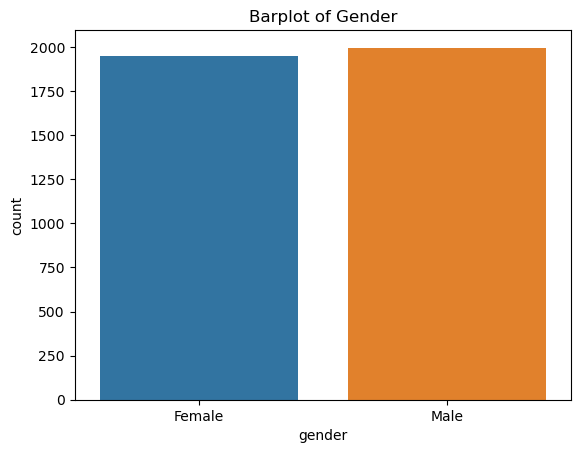

Value Frequency of Gender
        gender    gender
Male      1996  0.506214
Female    1947  0.493786


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




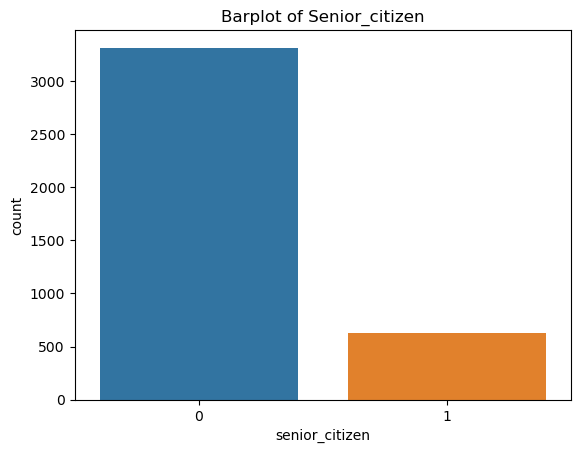

Value Frequency of Senior_citizen
   senior_citizen  senior_citizen
0            3318        0.841491
1             625        0.158509


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




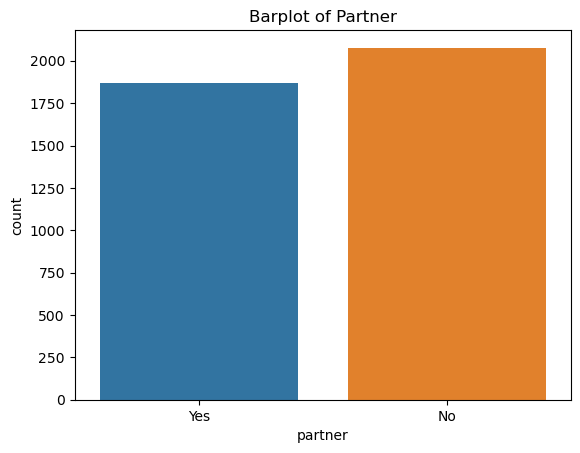

Value Frequency of Partner
     partner   partner
No      2077  0.526756
Yes     1866  0.473244


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




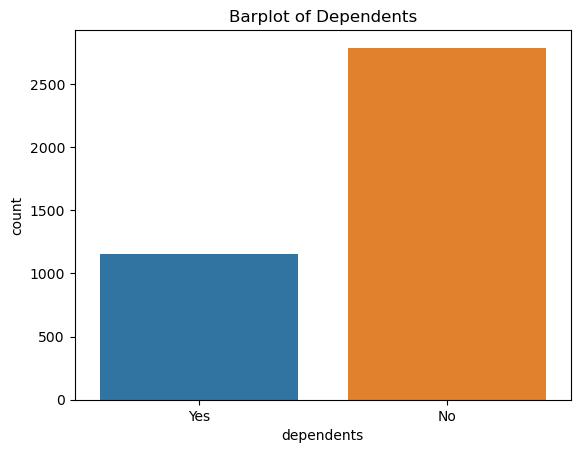

Value Frequency of Dependents
     dependents  dependents
No         2786    0.706569
Yes        1157    0.293431


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




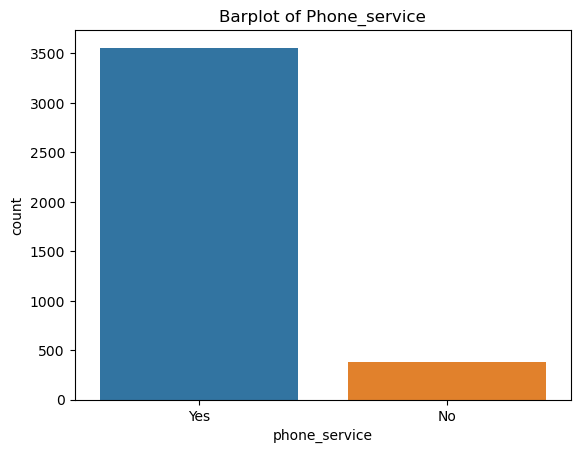

Value Frequency of Phone_service
     phone_service  phone_service
Yes           3559       0.902612
No             384       0.097388


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




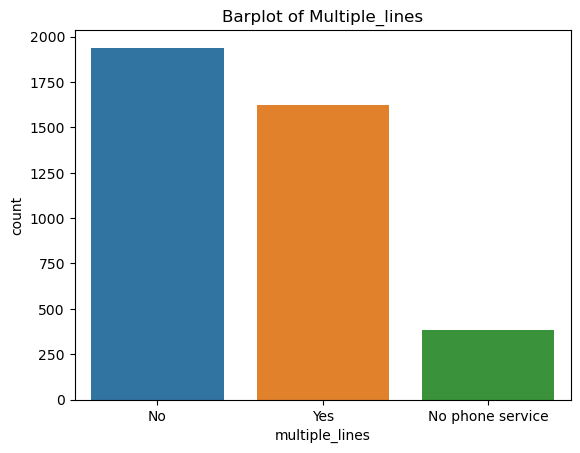

Value Frequency of Multiple_lines
                  multiple_lines  multiple_lines
No                          1939        0.491758
Yes                         1620        0.410855
No phone service             384        0.097388


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




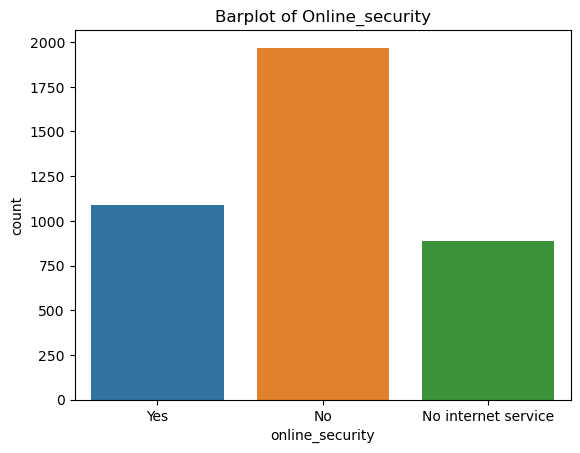

Value Frequency of Online_security
                     online_security  online_security
No                              1969         0.499366
Yes                             1088         0.275932
No internet service              886         0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




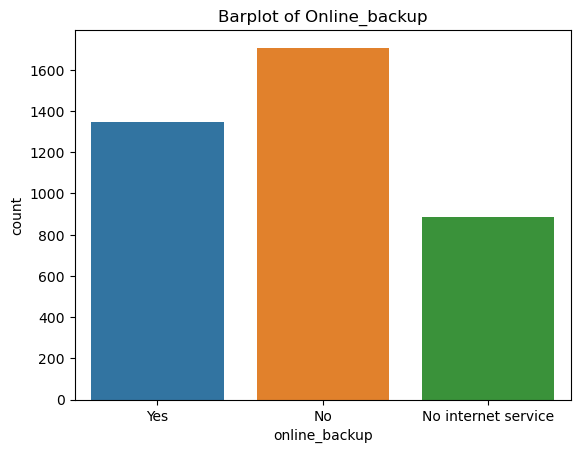

Value Frequency of Online_backup
                     online_backup  online_backup
No                            1708       0.433173
Yes                           1349       0.342125
No internet service            886       0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




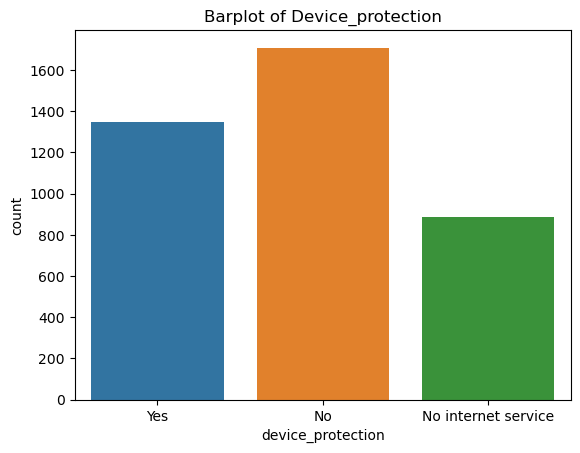

Value Frequency of Device_protection
                     device_protection  device_protection
No                                1709           0.433426
Yes                               1348           0.341872
No internet service                886           0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




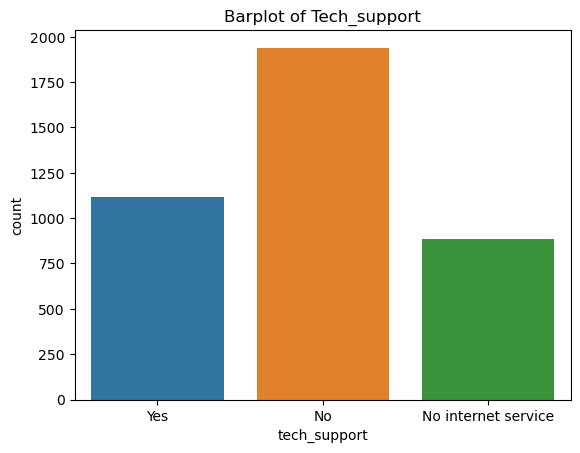

Value Frequency of Tech_support
                     tech_support  tech_support
No                           1940      0.492011
Yes                          1117      0.283287
No internet service           886      0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




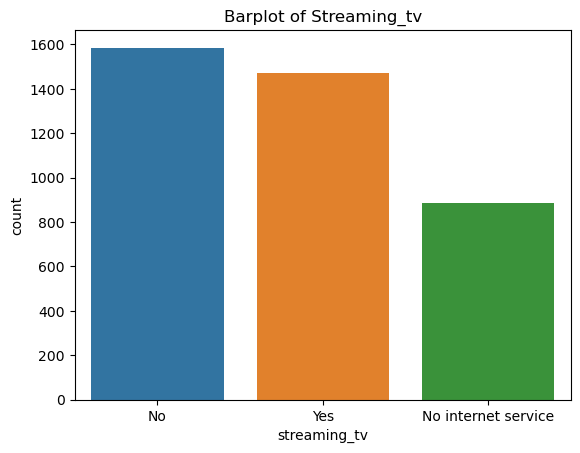

Value Frequency of Streaming_tv
                     streaming_tv  streaming_tv
No                           1586      0.402232
Yes                          1471      0.373066
No internet service           886      0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




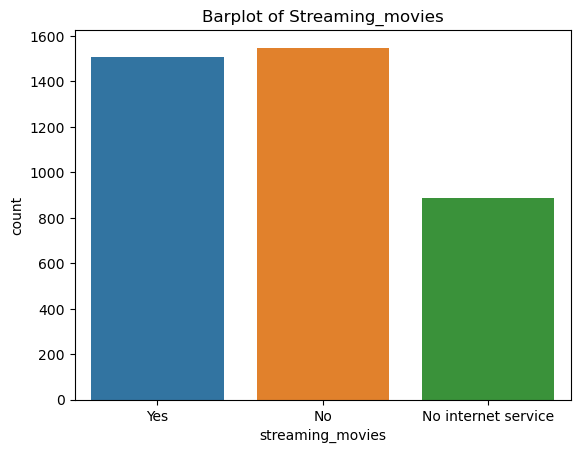

Value Frequency of Streaming_movies
                     streaming_movies  streaming_movies
No                               1549          0.392848
Yes                              1508          0.382450
No internet service               886          0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




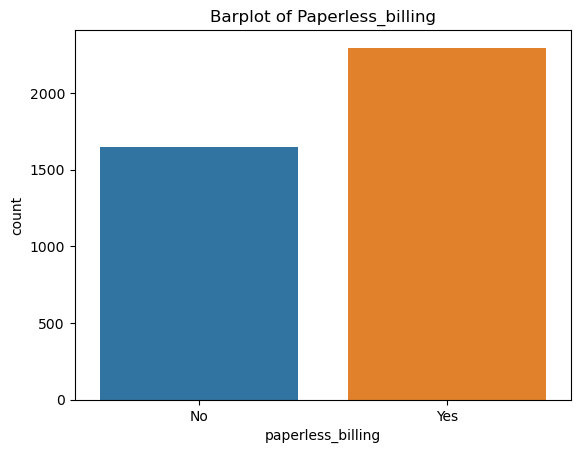

Value Frequency of Paperless_billing
     paperless_billing  paperless_billing
Yes               2296           0.582298
No                1647           0.417702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




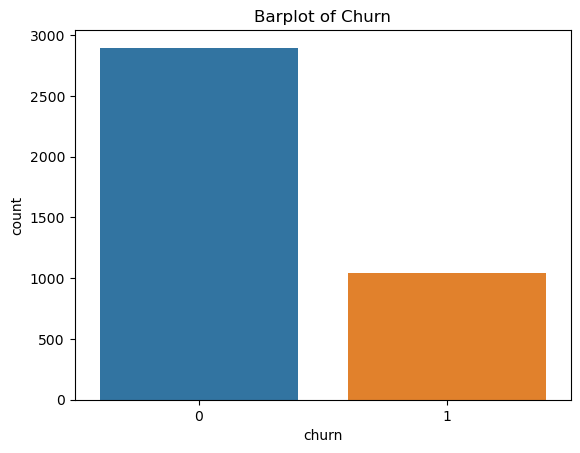

Value Frequency of Churn
   churn    churn
0   2897  0.73472
1   1046  0.26528


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




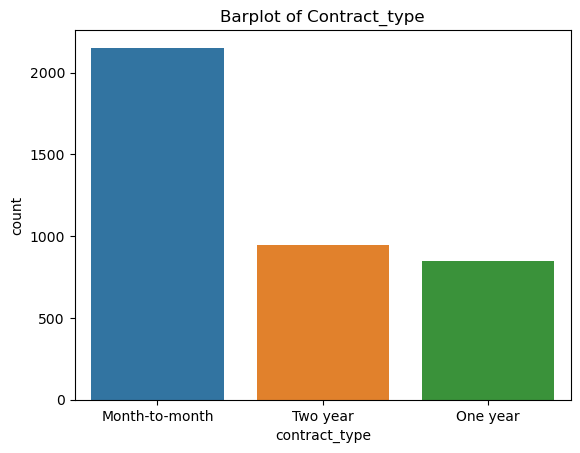

Value Frequency of Contract_type
                contract_type  contract_type
Month-to-month           2152       0.545777
Two year                  943       0.239158
One year                  848       0.215065


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




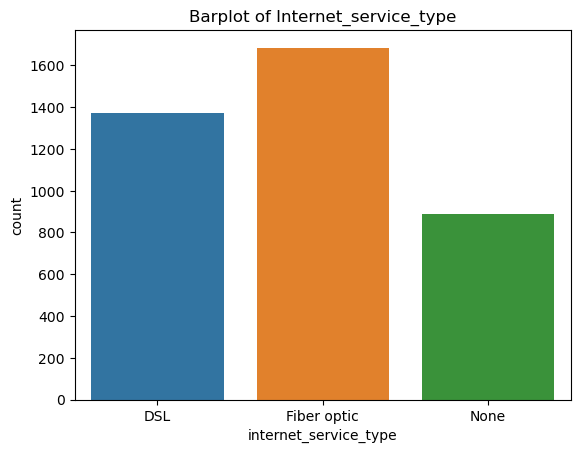

Value Frequency of Internet_service_type
             internet_service_type  internet_service_type
Fiber optic                   1685               0.427340
DSL                           1372               0.347958
None                           886               0.224702


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




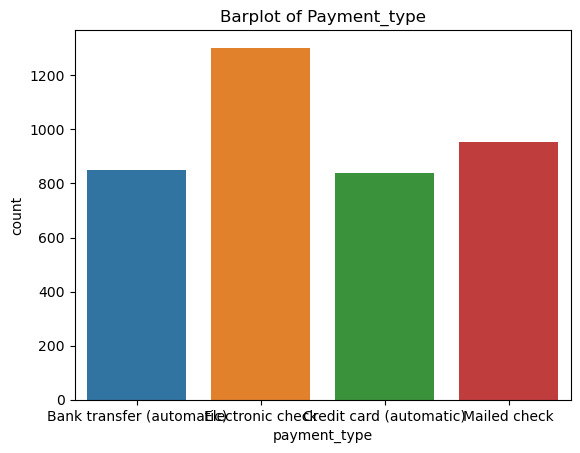

Value Frequency of Payment_type
                           payment_type  payment_type
Electronic check                   1302      0.330205
Mailed check                        955      0.242201
Bank transfer (automatic)           848      0.215065
Credit card (automatic)             838      0.212529


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




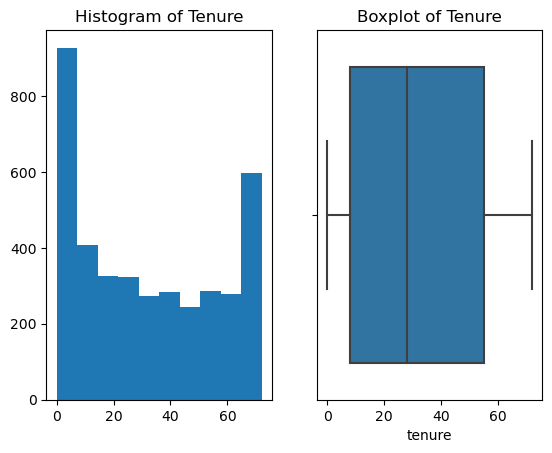

Summary statistics of Tenure:

count    3943.000000
mean       32.021557
std        24.451057
min         0.000000
25%         8.000000
50%        28.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




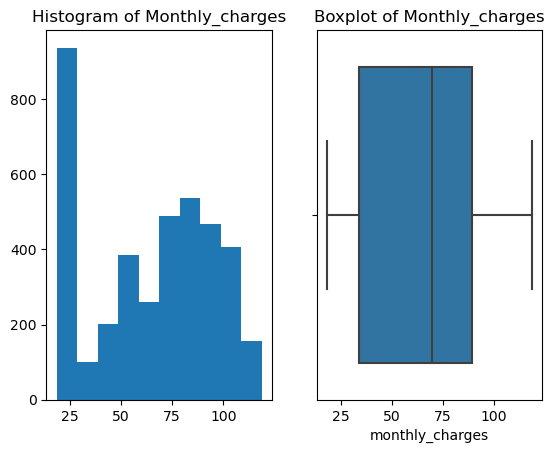

Summary statistics of Monthly_charges:

count    3943.000000
mean       63.903677
std        30.088609
min        18.400000
25%        34.000000
50%        69.750000
75%        89.425000
max       118.750000
Name: monthly_charges, dtype: float64


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




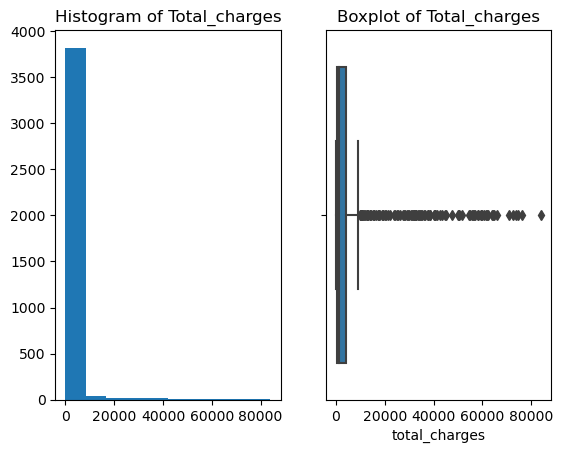

Summary statistics of Total_charges:

count     3943.000000
mean      3128.482564
std       6591.384020
min          0.000000
25%        414.350000
50%       1423.650000
75%       3992.325000
max      84050.000000
Name: total_charges, dtype: float64


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------




In [43]:
univariate_stats(train)

>>#### Takeaways:
>>- gender': mostly split evenly
>>- 'senior_citizen': only 16% of customers are senior citizens
    - There may be a relationship between senior citizen and the variety of addons
>>- 'partner': almost evenly split 
>>- 'dependents': 30% of user have dependents, 70% dont
    - dependents may also overlap a lot with the add-ons, i think it may be worth while to explore the relationship between the two
>>- 'tenure': The two largest individual bins are brand new or have been with the company for a while, while the majority of the clients are between 9 and 56 months ****Remember this is tenure, not when they churn****
    - There is a big drop off after the initial sign up
    - I want to explore the realtionship between tenure, contract type, and churn, also looking into the influences on tenure becuase it is directyl related to everythin. What keeps pepole staying? Who are the poeple that are staying? Do they have children? Do they have add ones? are they streaming? What about the people? Is the drop in tenure related to promotions or is it a show of how people churn?
>>- 'phone_service': majority(90%) has phone service
>>- 'multiple_lines': 49% have mulitple, 10% have nophone, 40% has phone service
    - may be useful to segment customers that do not have phone service vs having phone service
>>- 'online_security': only 29% of customers have online sercurity, and almost 50% dont have it. 25% dont have internet
>>- 'online_backup': 34% of people have the onlint back-up, a little more than online security, there may be overlep in these two groups
    - May be useful to ecplore the overlapp between online security and online backup
>>- 'device_protection': 34% of people have device protection as well with roughly even dirtubution of people with these features
    - There seems to be a trend in the stats for these features
>>- 'tech_support': Tech support appears to have a drop down to 28%
>>- 'streaming_tv': this is a larger boost with roughly 38% with tv streaming, its likely that people with dependents, non
>>- 'streaming_movies':
    - it may be useful to combine streaming movies and stresming_tv togethe into one group 'streaming_services' but that will be an extra thing i'll do later
>>- 'paperless_billing': 58% have paperless billing, 42% dont
>>- 'monthly_charges': I'm assuming the addpon (mulitple lines, streaming, protections, etc) are directly related to the charges. 
    - I also think therea will be a relationship to tenure, with the very low costs belonging to the lower tenures. What is more expensive? What costs more and what costs less? Does this impact churn? Can I find out if there is a realtion ship between costs, add-ons, churn, and which are more useful to the consumer?
>>- 'total_charges': The total charges seems wild to me.
    - I'm curious but why are there some clients with expremely high total charges? I think i may need to do some calucations of monhtly charges and tenure to make sure the data is correct. I believe there may be an error in this data with so many outliers present. 
>>- 'churn': 73% of people stay while 27% of people leave/churn
>>- 'contract_type': 54% have month to month, one 25% have 2 year contracts, and 21% percent have one year contracts
>>- 'internet_service_type': 22.5% dont have internet, 34.1% have dsl, 43.4% have fiber
>>- 'payment_type': 33.4% have electronic checks with all others arounf 22%

>>#### Actions
>>- none of the num variables are normally distributed
>>- down the line: change all the values in the table to pyhton formatted strings

>### Bivariate analysis questions:

In [44]:
def bivariate_stats(train, focus = 'all'):
    '''
    
    '''
    explore_col, cat_col, num_col = determine_variable_type(train)
    
    target = 'churn'
    
    if focus == 'all':
        for col in cat_col:
            if col != target:
                sns.barplot(data=train,
                            x=col, 
                            y=target)
                plt.axhline(train[target].mean(), c='r')
                plt.title(f'{target.capitalize()} by {col.capitalize()} Barplot')
                plt.show()

        for col in num_col:
            if col != target:
                plt.subplot(121)
                sns.barplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')

                plt.subplot(122)
                sns.boxplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')
                plt.show()
    elif focus == 'cat':
        for col in cat_col:
            if col != target:
                sns.barplot(data=train,
                            x=col, 
                            y=target)
                plt.axhline(train[target].mean(), c='r')
                plt.title(f'{target.capitalize()} by {col.capitalize()} Barplot')
                plt.show()
    elif focus == 'num':
        for col in num_col:
            if col != target:
                plt.subplot(121)
                sns.barplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')

                plt.subplot(122)
                sns.boxplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')
                plt.show()
    return

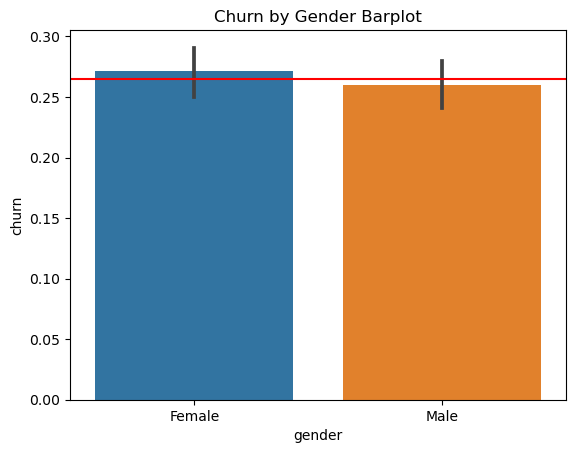

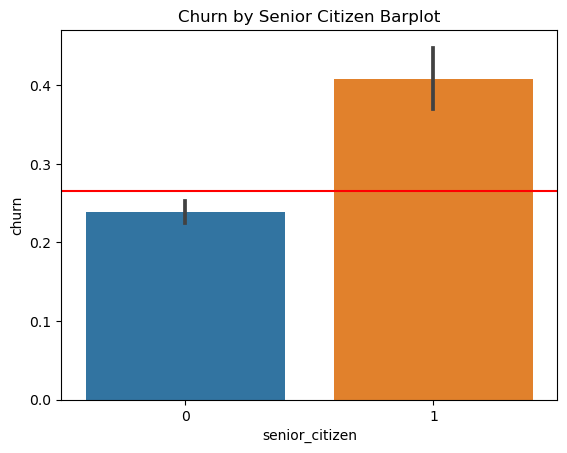

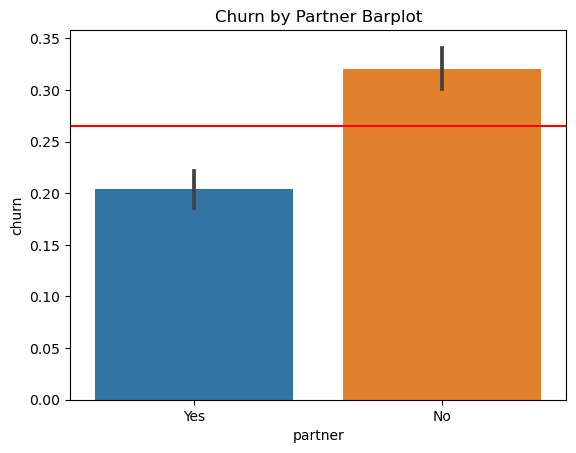

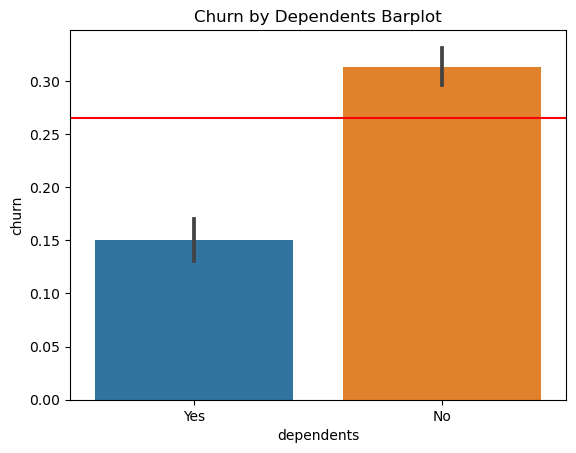

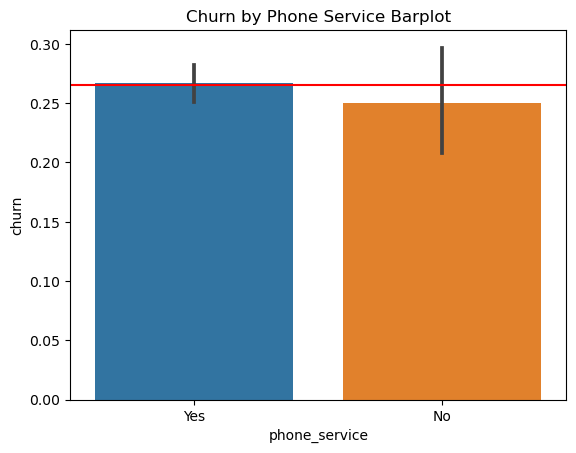

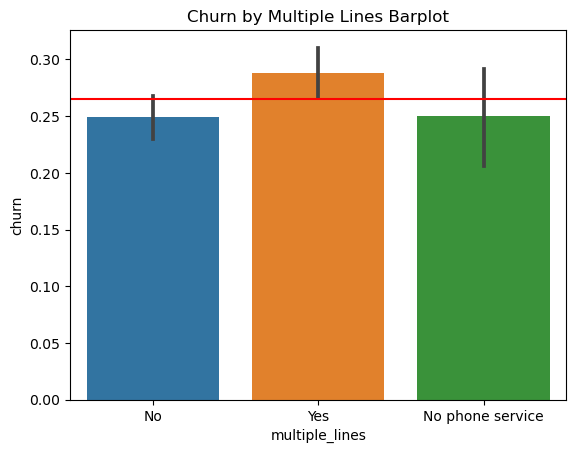

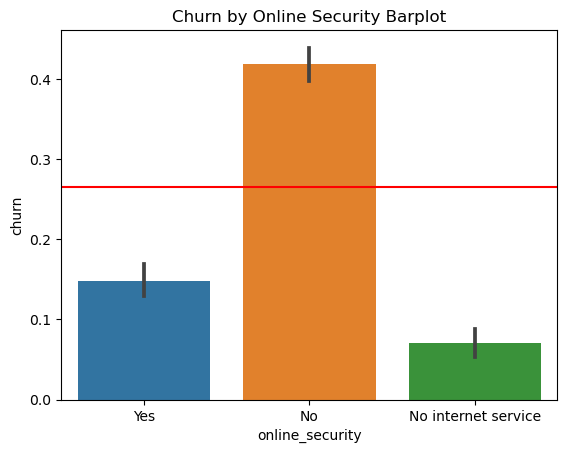

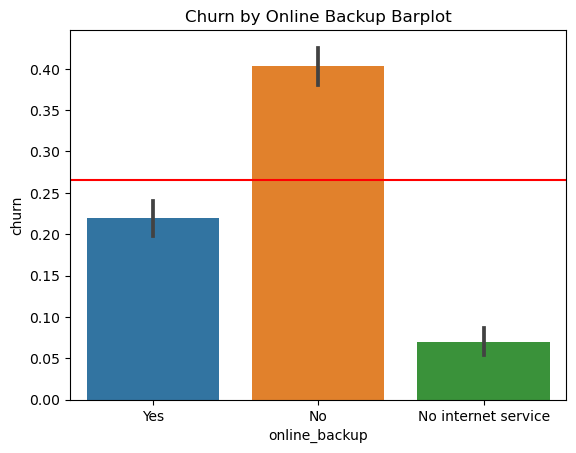

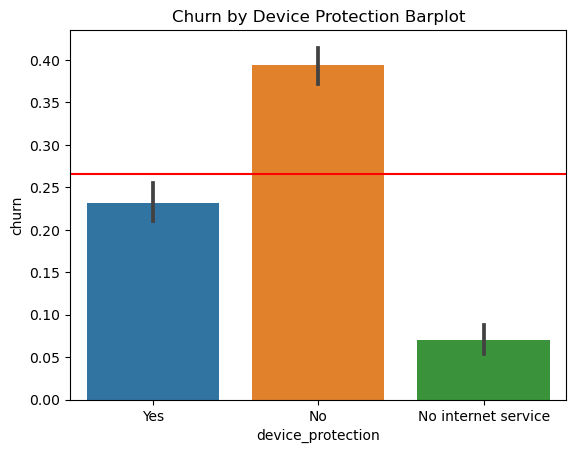

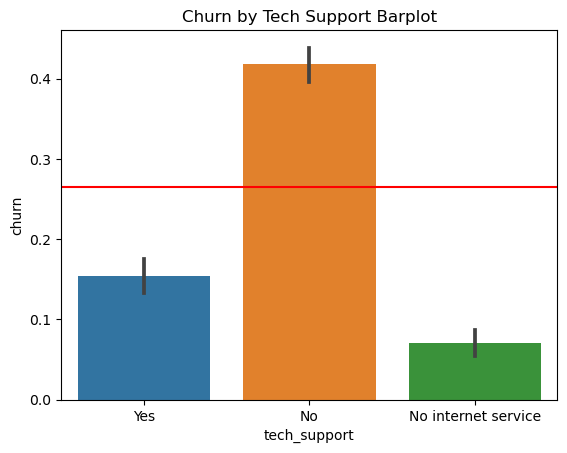

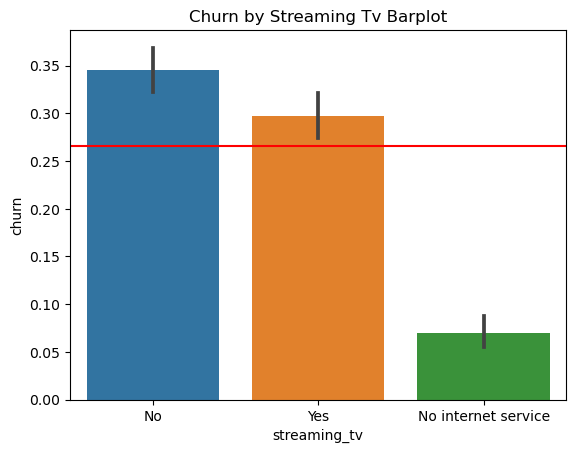

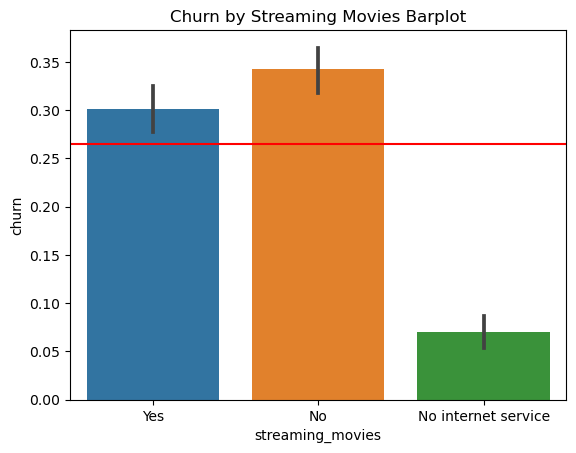

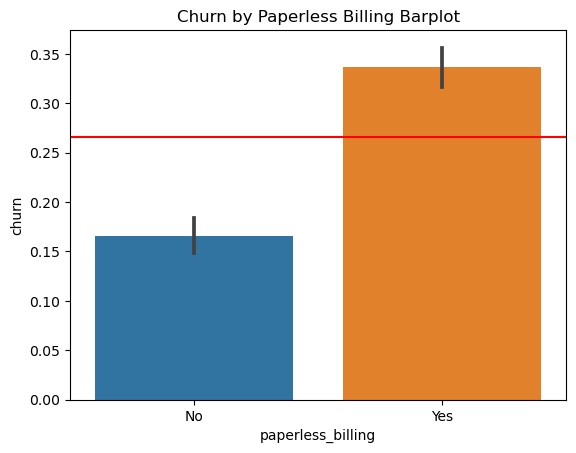

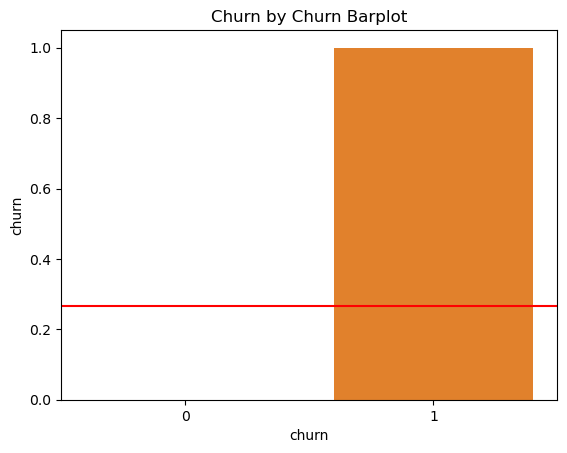

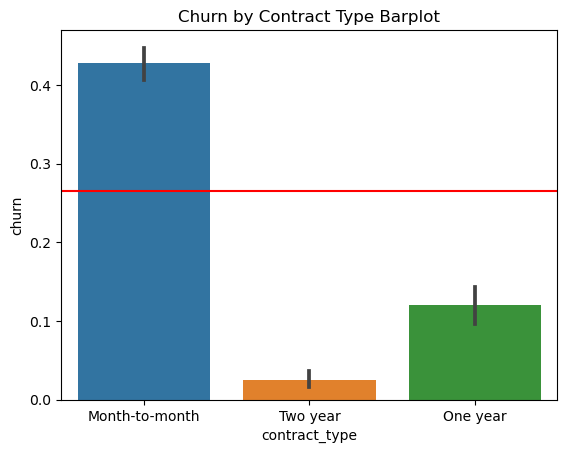

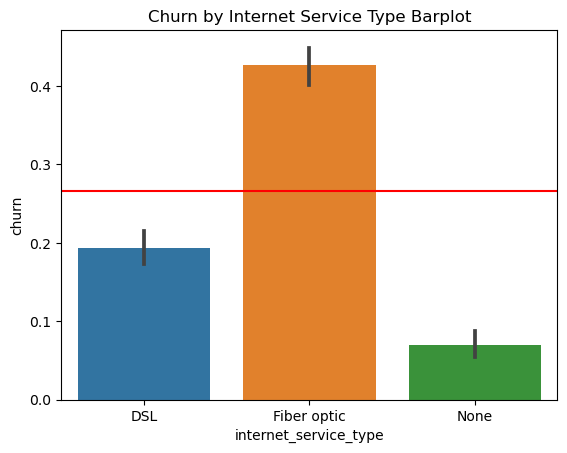

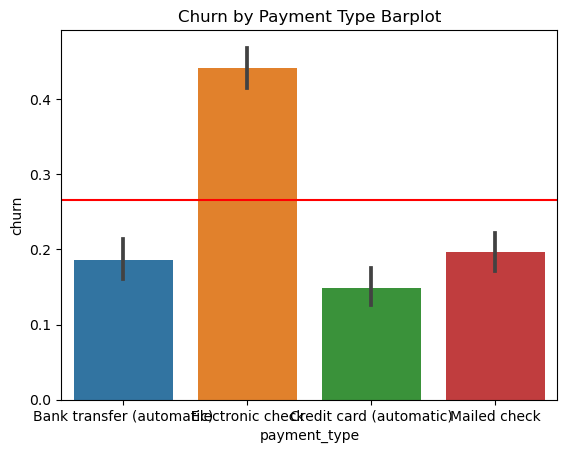

In [45]:
import string
explore_col, cat_col, num_col = determine_variable_type(train)
target = 'churn'
for col in cat_col:
    if 'yes' not in col and 'no' not in col and 'type_' not in col: 
        sns.barplot(data=train,
                        x=col, 
                        y=target)
        plt.axhline(train[target].mean(), c='r')
        col = string.capwords(col.replace('_', ' '))
        plt.title(f'{target.capitalize()} by {col} Barplot')
        plt.show()

In [46]:

def telco_core_services():
    '''
    This function creates a subplot of two variables of interest
    '''
    
    target = 'churn'
    plt.subplot(121)
    sns.barplot(data=train,
                    x=train['phone_service'], 
                    y=target)
    plt.axhline(train[target].mean(), c='r')
    plt.title(f'Phone Services\n{target.capitalize()} Barplot')
    plt.xlabel('Phone Service')
    plt.ylabel(target.capitalize())
    
    plt.subplot(122)
    sns.barplot(data=train,
                    x=train['internet_service_type'], 
                    y=target)
    plt.axhline(train[target].mean(), c='r')
    plt.title(f'Internet Service Type\n{target.capitalize()} Barplot')    
    plt.xlabel('Internet Service Type')
    plt.ylabel(target.capitalize())
    plt.tight_layout()
    plt.show()
    
    return

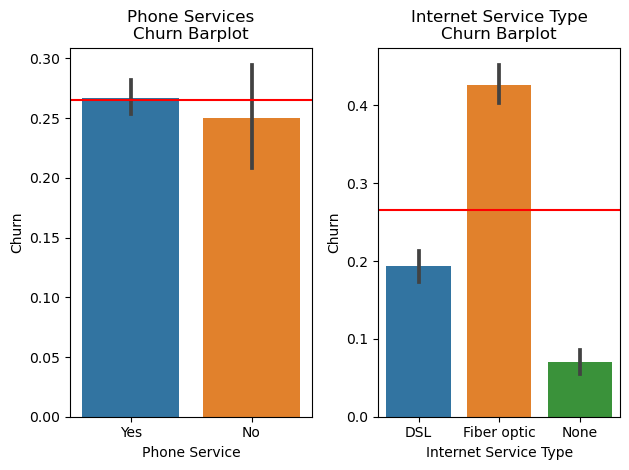

In [47]:
telco_core_services()

>>>- Is there a relationship between churn and:
    - 'gender': very small, no
    - **'senior_citizen'**: yes, older people churn at a higher proportion
    - **'partner'**: single people churn more than partnered people
    - **'dependents'**: people w/o dependents churn more than people with dependents
    - **'tenure'**: 
        - people with higher tenure are leaving
    - 'phone_service',
    - 'multiple_lines',
    - ***Suspected Subset***
        - **'online_security'**:
            - people without internet churn less
            - people without online security churn less
        - '**online_backup'**:
            - people without backup churn at more
        - **'device_protection'**,
        - '**tech_support'**,
    - ***Suspected Subset***
        - **'streaming_tv'**,
        - **'streaming_movies'**,
    - ***Potential Subset/Relationship***
        - **'paperless_billing'**: I think this is related to having internet
        - **'payment_type**:
            - paperless billing is 
    - **'monthly_charges'**: people payonig over the average monhtly charge amount are churnning more
    - 'total_charges',
    - 'churn',
    - **'contract_type'**
        - month to month has a higher churn rate
    - **'internet_service_type'**,
        - fiber optic churns at a high rate
        
 >>> Actions: Loonk into the potential subsets, if they're the same people, create a new column that shows that

In [48]:
def telco_internet_service_supports(train):
    '''
    Arguments: telco train dataset
    Actions:
        1. Creates 4 subplots for online_security, online_backup, device_protection, tech_support
        2. Subplots relflect each values churn rate
        3. Subployts have horizontal line representing overall churn rate
    Modules: string, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
    '''
    
    # intiialize target variable as churn
    target = 'churn'
    
    # initializing variable for x axis
    col = 'online_security'
    
    # creatins title/label friendly column by replacing the underscore and capitalizing all first letters
    col_text = string.capwords(col.replace('_',' '))
    
    # assigning subplot position
    plt.subplot(221)
    
    # creatins a barplot with train data
    sns.barplot(data=train,
                    
                    # setting x axis to the variable previously initialized
                    x=train[col], 
                
                    # setting y axis to the target
                    y=target)
    
    # setting the overall average churn rate as a horizontal line in the graphs
    plt.axhline(train[target].mean(), c='r')
    
    # inserting the title
    plt.title(f'{col_text}\n{target.capitalize()} Barplot')
    
    # labeling the x axis
    plt.xlabel(f'{col_text}')
    
    # labeling the y axis
    plt.ylabel(target.capitalize())
    

    # initializing variable for x axis
    col2 = 'online_backup'
    # exit function
    
    # creatins title/label friendly column by replacing the underscore and capitalizing all first letters
    col2_text = string.capwords(col2.replace('_',' '))
    
    # assigning subplot position
    plt.subplot(222)
    
    # creatins a barplot with train data
    sns.barplot(data=train,
                    
                    # setting x axis to the variable previously initialized
                    x=train[col2], 
                
                    # setting y axis to the target
                    y=target)
    
    # setting the overall average churn rate as a horizontal line in the graphs
    plt.axhline(train[target].mean(), c='r')
    
    # inserting the title
    plt.title(f'{col2_text}\n{target.capitalize()} Barplot')    
    
    # labeling the x axis
    plt.xlabel(f'{col2_text}')
    
    # labeling the y axis
    plt.ylabel(target.capitalize())
    
    # formating the subplots to reduce overlap
    plt.tight_layout()
    

    # initializing variable for x axis
    col2 = 'device_protection'
    
    # creatins title/label friendly column by replacing the underscore and capitalizing all first letters
    col2_text = string.capwords(col2.replace('_',' '))
    
    # assigning subplot position
    plt.subplot(223)
    
    # creatins a barplot with train data
    sns.barplot(data=train,
                    
                    # setting x axis to the variable previously initialized
                    x=train[col2], 
                
                    # setting y axis to the target
                    y=target)
    
    # setting the overall average churn rate as a horizontal line in the graphs
    plt.axhline(train[target].mean(), c='r')
    
    # inserting the title
    plt.title(f'{col2_text}\n{target.capitalize()} Barplot')    
    
    # labeling the x axis
    plt.xlabel(f'{col2_text}')
    
    # labeling the y axis
    plt.ylabel(target.capitalize())
    
    # formating the subplots to reduce overlap
    plt.tight_layout()


    # initializing variable for x axis
    col2 = 'tech_support'
    
    # creatins title/label friendly column by replacing the underscore and capitalizing all first letters
    col2_text = string.capwords(col2.replace('_',' '))
    
    # assigning subplot position
    plt.subplot(224)
    
    # creatins a barplot with train data
    sns.barplot(data=train,
                    
                    # setting x axis to the variable previously initialized
                    x=train[col2], 
                
                    # setting y axis to the target
                    y=target)
    
    # setting the overall average churn rate as a horizontal line in the graphs
    plt.axhline(train[target].mean(), c='r')
    
    # inserting the title
    plt.title(f'{col2_text}\n{target.capitalize()} Barplot')    
    
    # labeling the x axis
    plt.xlabel(f'{col2_text}')
    
    # labeling the y axis
    plt.ylabel(target.capitalize())
    
    # formating the subplots to reduce overlap
    plt.tight_layout()
    
    # showing all the subplots together
    plt.show()
    
    # exit function
    return


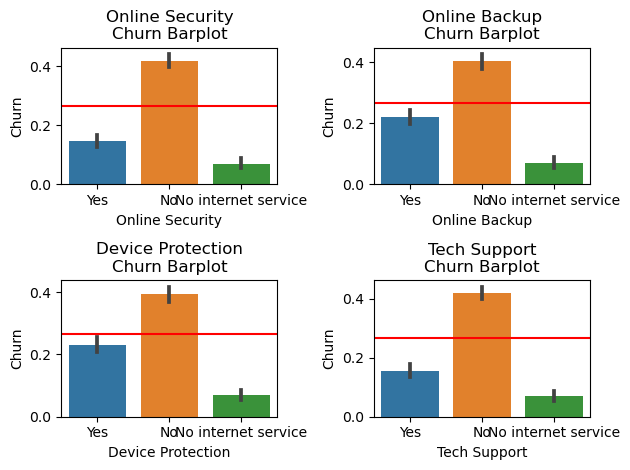

In [49]:
telco_internet_service_supports()

In [1]:
def telco_streaming_services(train):
    '''
    This function creates a subplot of two variables of interest
    Modules: string, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
    '''

    target = 'churn'
    
    # initializing variable for x axis
    col = 'streaming_movies'
    
    # creating title/label friendly column by replacing the underscore and capitalizing all first letters
    col_text = string.capwords(col.replace('_',' '))
    
    # assigning subplot position
    plt.subplot(121)
    
    # creating a barplot with train data
    sns.barplot(data=train,
                
                    # setting x axis to the variable previously initialized
                    x=train[col], 
                    
                    # setting y axis to the target
                    y=target)
    
    # setting the overall average churn rate as a horizontal line in the graphs
    plt.axhline(train[target].mean(), c='r')
    
    # inserting the title
    plt.title(f'{col_text}\n{target.capitalize()} Barplot')
    
    # labeling the x axis
    plt.xlabel(f'{col_text}')
    
    # labeling the y axis
    plt.ylabel(target.capitalize())
    
    # initializing variable for x axis
    col2 = 'streaming_tv'
    
    # creating title/label friendly column by replacing the underscore and capitalizing all first letters
    col2_text = string.capwords(col2.replace('_',' '))
    
    # assigning subplot position
    plt.subplot(122)
    
    # creating a barplot with train data
    sns.barplot(data=train,
                
                    # setting x axis to the variable previously initialized
                    x=train[col2], 
                    
                    # setting y axis to the target
                    y=target)
    
    # setting the overall average churn rate as a horizontal line in the graphs
    plt.axhline(train[target].mean(), c='r')
    
    # inserting the title
    plt.title(f'{col2_text}\n{target.capitalize()} Barplot')    
    
     # labeling the x axis
    plt.xlabel(f'{col_text}')
    
    # labeling the y axis
    plt.ylabel(target.capitalize())
    
    # formating the subplots to reduce overlap
    plt.tight_layout()

    # showing all plaots
    plt.show()
    
    # exit function
    return


In [ ]:


def determine_variable_type(train):
    '''
    Arguments: a train dataset
    Actions:
        1. Assigns columns names to categorical columns list or numerical columns list
            a. Categorical columns: the datatype is object or there are less than 10 unique values 
            b. Numerical columns: the datatype is not an object and thhere are 10 or more unique values
    Returns: explore_columns_list, categorical_column_list, numerical_column_list
    Modules: pandas
    
    '''
    # list comprehension that determines a col is  categorical if the data type is an object or there are less than 10 values
    cat_col = [col for col in train if train[col].dtype == 'O' or train[col].nunique() < 10]
    
    # list comprehension that complements the above
    num_col = [col for col in train if train[col].dtype != 'O' and train[col].nunique() >= 10]
    
    # full list of variables to explore
    explore_col = cat_col + num_col
    
    return explore_col, cat_col, num_col





def univariate_stats(train):
    '''
    Parameters: *only* a train dataset as an argument
    Actions:
        1. Creates univariate datavisuals for all variables in the dataset
        2. Displays summary statistics for variables with more than 5 unique values
    Returns: prints summary stats and graphs to understand the data
    Modules: searborn, matplotlib.pyplot, 
    '''
    explore_col, cat_col, num_col = determine_variable_type(train)
    
    for col in explore_col:
        if col in cat_col:
            sns.countplot(data=train, x=col,)
            plt.title(f'Barplot of {col.capitalize()}')
            plt.show()
            print(f'Value Frequency of {col.capitalize()}')
            print(pd.concat([train[col].value_counts(),
            train[col].value_counts(normalize=True)],
                 axis=1))
            print('\n\n------------------------------------------------------------------------------------------\n------------------------------------------------------------------------------------------\n\n')
        elif col in num_col:
            plt.subplot(121)
            plt.hist(train[col])
            plt.title(f'Histogram of {col.capitalize()}')
            
            plt.subplot(122)
            sns.boxplot(data=train, x=col)
            plt.title(f'Boxplot of {col.capitalize()}')
            plt.show()
            
            print(f'Summary statistics of {col.capitalize()}:\n')
            print(train[col].describe())
            print('\n\n------------------------------------------------------------------------------------------\n------------------------------------------------------------------------------------------\n\n')
    return

def bivariate_stats(train, focus = 'all'):
    '''
    
    '''
    explore_col, cat_col, num_col = determine_variable_type(train)
    
    target = 'churn'
    
    if focus == 'all':
        for col in cat_col:
            if col != target:
                sns.barplot(data=train,
                            x=col, 
                            y=target)
                plt.axhline(train[target].mean(), c='r')
                plt.title(f'{target.capitalize()} by {col.capitalize()} Barplot')
                plt.show()

        for col in num_col:
            if col != target:
                plt.subplot(121)
                sns.barplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')

                plt.subplot(122)
                sns.boxplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')
                plt.show()
    elif focus == 'cat':
        for col in cat_col:
            if col != target:
                sns.barplot(data=train,
                            x=col, 
                            y=target)
                plt.axhline(train[target].mean(), c='r')
                plt.title(f'{target.capitalize()} by {col.capitalize()} Barplot')
                plt.show()
    elif focus == 'num':
        for col in num_col:
            if col != target:
                plt.subplot(121)
                sns.barplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')

                plt.subplot(122)
                sns.boxplot(data=train,
                           x=target,
                           y=col)
                plt.axhline(train[col].mean(), c='r')
                plt.show()
    return


In [51]:
telco_streaming_services()

TypeError: telco_streaming_services() missing 1 required positional argument: 'train'

In [ ]:
# checking for similarities in these 
(train['streaming_tv'] == train['streaming_movies']).value_counts()

# over 20% are not the same, will not bin these together
3069 / (3069 + 874)

In [ ]:
(train['online_backup'] == train['online_security']).value_counts()
(train['online_backup'] == train['device_protection']).value_counts()

> ### Hypothesis Testing Variables of Interest

In [ ]:
from scipy  import stats

> Variables:Tenure
>>#### H$_0$: tenure of people who churn >= monthly charges of peopl
>>#### H$_a$: tenure of people who churn < monthly charges of peopl
>>#### Sample: 2 sample
>>#### Tails/Directionality: 1 tailed
>>#### Normality: no
>>#### Test: 

> Variables: Monthly Charges
>>#### H$_0$: monthly charges of people who churn =< monthly charges of customers who dont churn
>>#### H$_a$:monthly charges of people who churn > monthly charges of customers who dont churn
>>#### Sample: 2 sample
>>#### Tails/Directionality: 1 tailed
>>#### Test: 

In [ ]:
# creating list of columns of interst based on whether they are cat or num
interest_cat = ['senior_citizen', 
                    'partner',
                    'dependents',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'paperless_billing',
                    'contract_type',
                    'internet_service_type',
                    'payment_type']


interest_num = ['tenure', 'monthly_charges']

interest_col = ['churn'] + interest_cat + interest_num

In [ ]:
# Creating a function display the resukts of the $x^2$ test
def chi_squared_telco(train, ls):
    '''
    Action:
    
    Modules: scipy.stats
    '''
    
    
    target = 'churn'
    α = 0.05
    dependent_cols = []
    for col in ls:
        observed = pd.crosstab(train[target], train[col])
        chi2, p, degf, expected = stats.chi2_contingency(observed)
        if p < α:
            dependent_cols.append(col)
        else:
            print(f'There is not a significant relationship between {target} and {col}. \nWe \033[1mcannot reject\033[0m the Null Hypothesis. (p-value: {p})')
    return dependent_cols

In [ ]:
target = 'churn'
α = 0.05
dependent_cols = []
for col in interest_cat:
    print(f'\n\nVariable of Interest: {col.upper()}')
    print(f'''\033[1mNull Hypothesis:\033[0m This is no relationship between {target} and {col}.\n\033[1mAlternative Hypothesis:\033[0m There is some relationship between {target} and {col}.
''')
    observed = pd.crosstab(train[target], train[col])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    
    if p < α:
        print(f'There exists some relationship between {target} and the {col}. \nWe \033[1mreject\033[0m the null hypothesis. (p-value: {p})')
        dependent_cols.append(col)
    else:
        print(f'There is not a significant relationship between {target} and {col}. \nWe \033[1mcannot reject\033[0m the Null Hypothesis. (p-value: {p})')

In [ ]:
def chi_squared_single(train, col):
    '''
    Action:
    
    Modules: scipy.stats
    '''
    
    target = 'churn'
    α = 0.05
    observed = pd.crosstab(train[target], train[col])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f'p-value:{round(p, 4)}\nchi2: {round(chi2,4)}')
    if p < α:
        print(f'There exists some relationship between {target} and the {col}. \nWe \033[1mreject\033[0m the null hypothesis.')
    else:
        print(f'There is not a significant relationship between {target} and {col}. \nWe \033[1mcannot reject\033[0m the Null Hypothesis.')
    return 


In [ ]:
chi_squared_single(train, 'internet_service_type')

In [ ]:
def chi_squared_multiple(train, ls):
    '''
    Action:
    
    Modules: scipy.stats
    '''
    
    target = 'churn'
    α = 0.05
    dependent_cols = []
    for col in ls:
        print(f'\n\nVariable of Interest: {col.upper()}')
        print(f'''\033[1mNull Hypothesis:\033[0m This is no relationship between {target} and {col}.\n\033[1mAlternative Hypothesis:\033[0m There is some relationship between {target} and {col}.''')
        observed = pd.crosstab(train[target], train[col])
        chi2, p, degf, expected = stats.chi2_contingency(observed)
        if p < α:
            print(f'There exists some relationship between {target} and the {col}. \nWe \033[1mreject\033[0m the null hypothesis. (p-value: {p})')
            dependent_cols.append(col)
        else:
            print(f'There is not a significant relationship between {target} and {col}. \nWe \033[1mcannot reject\033[0m the Null Hypothesis. (p-value: {p})')
    return dependent_cols

### Preprocessing

In [ ]:
### ACTION: FOR PREPROCESSING GO BACK AND TRIM THE DF IN THE PREP DOCUMENT

In [52]:
train, validate, test = prep_telco(clean_telco(get_telco_data()), base_explore=False)

/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/1633238232.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')
/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/1633238232.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')


In [ ]:
train.columns.to_list()

In [75]:
def chi_squared_dependent_cat_cols(train):
    '''
    Action:
    
    Modules: scipy.stats
    '''
    
    target = 'churn'
    α = 0.05
    dependent_cols = []
    for col in train:
        if train[col].nunique() < 10 and col != 'churn' and col != 'multiple_lines':
            observed = pd.crosstab(train[target], train[col])
            chi2, p, degf, expected = stats.chi2_contingency(observed)
            if p < α:
                dependent_cols.append(col)
            
    return dependent_cols

In [54]:
columns_used = chi_squared_dependent_cat_cols(train)



Variable of Interest: SENIOR_CITIZEN
Null Hypothesis: This is no relationship between churn and senior_citizen.
Alternative Hypothesis: There is some relationship between churn and senior_citizen.
There exists some relationship between churn and the senior_citizen. 
We reject the null hypothesis. (p-value: 9.550330445599293e-24)


Variable of Interest: GENDER_MALE
Null Hypothesis: This is no relationship between churn and gender_male.
Alternative Hypothesis: There is some relationship between churn and gender_male.
There is not a significant relationship between churn and gender_male. 
We cannot reject the Null Hypothesis. (p-value: 0.2817544129016075)


Variable of Interest: PARTNER_YES
Null Hypothesis: This is no relationship between churn and partner_yes.
Alternative Hypothesis: There is some relationship between churn and partner_yes.
There exists some relationship between churn and the partner_yes. 
We reject the null hypothesis. (p-value: 9.472649408988687e-18)


Variable of In

In [55]:
columns_used.append('phone_service')

In [56]:
columns_used.append('churn')

In [57]:
def model_prep(train, validate, test):
    '''
    
    '''
    dependent_cat_cols = chi_squared_dependent_cat_cols(train)
    
    X_train = train[dependent_cat_cols]
    y_train = train.churn

    X_val = validate[dependent_cat_cols]
    y_val = validate.churn

    X_test = test[dependent_cat_cols]
    y_test = test.churn
    
    return X_train, y_train, X_val, y_val, X_test, y_test


### Model

In [ ]:
baseline = np.zeros(len(train.churn))

In [ ]:
tn, fn, fp, tp = confusion_matrix(y_train, baseline).ravel()
accuracy = (tn + tp) / (tn + tp + fn + fp)
tn, fn, fp, tp, accuracy

> Decision Tree
>- Because we are looking at churn, incorrectly identifying non-churn results in unexpected loss. The number we want to be highest is the false negative rate
>- In the case of false positives, it may result in pushing extra discounts to the oerson we predict to churn, but this may boost the customers loyalty to our company. We still want a relatively low false positive rate

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
X_train = train[dependent_cat_cols]
y_train = train.churn

X_val = validate[dependent_cat_cols]
y_val = validate.churn

X_test = test[dependent_cat_cols]
y_test = test.churn

In [ ]:
# make it
clf = DecisionTreeClassifier()

# fit it
clf.fit(X_train, y_train)

# prediction
y_preds = clf.predict(X_train)

In [ ]:
# Evaluate it
print(classification_report(y_train, y_preds))

In [ ]:
one_start = [i for i in range(1,11)]
ten_start =  [i for i in range(1,11)]
ten_start.reverse()
model_dict = {}

for o in one_start:
    for t in one_start:
        # initial model with min samp of 01 and max depth of 10
        clf = DecisionTreeClassifier(min_samples_leaf=o, max_depth=t)
        # fitting the model to the training ds
        clf.fit(X_train, y_train)
        # storing predicted values to the variable
        clf_preds = clf.predict(X_train) 
        clf_val_preds = clf.predict(X_val) 
        
        clf_confusion = confusion_matrix(y_train, clf_preds)
        tp_clf = clf_confusion[1,1]
        tn_clf = clf_confusion[0,0]
        fp_clf = clf_confusion[0,1]
        fn_clf = clf_confusion[1,0]
        
        
        accuracy = round((tp_clf + tn_clf) / (tp_clf+ tn_clf + fp_clf + fn_clf), 4)
        true_postive_rate = round(tp_clf / (tp_clf + fn_clf), 4)
        false_positive_rate = round(fp_clf / (tn_clf + fp_clf), 4)
        true_negative_rate = round((tn_clf) / (tn_clf + fp_clf), 4)
        false_negative_rate = round((fn_clf) / (tp_clf + fn_clf), 4)
        clf_precision = round((tp_clf) / (tp_clf + fp_clf), 4)
        clf_recall = round((tp_clf) / (tp_clf + fn_clf), 4)
        f1 = round(2 * (clf_precision * clf_recall) / (clf_precision + clf_recall), 4)
        
        model_dict[f'rf_samp{o}_max{t}'] = {}
        model_dict[f'rf_samp{o}_max{t}']['model'] = clf
        model_dict[f'rf_samp{o}_max{t}']['train_score'] = clf.score(X_train, y_train)
        model_dict[f'rf_samp{o}_max{t}']['val_score'] = clf.score(X_val, y_val)
        model_dict[f'rf_samp{o}_max{t}']['train_val_score_difference'] = clf.score(X_train, y_train) - clf.score(X_val, y_val)
        
        if false_negative_rate < .25:
            print(f'''

            Model: CLF {o}|{t}
            Accuracy: {accuracy:.2%}
            False Positive Rate: {false_positive_rate:.2%}
            True Negative Rate: {true_negative_rate:.2%}
            False Negative Rate: {false_negative_rate:.2%}
            F1: {f1:.2%}
            Validation Set Classification Report:

            {classification_report(y_val, clf_val_preds)}
            ''')

> Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [ ]:
def telco_best_rf(X_train, y_train, X_val, y_val):
    '''
    
    '''

    # initial model with min samp of 01 and max depth of 10
    clf = RandomForestClassifier(max_depth=4)

    # fitting the model to the training ds
    clf.fit(X_train, y_train)

    # storing predicted values to the variable
    y_preds = clf.predict(X_train)  

    tn, fn, fp, tp = confusion_matrix(y_train, y_preds).ravel()
    fn_rate = fn / (fn + tp)
    score = clf.score(X_train, y_train)


    y_val_preds = clf.predict(X_val)
    tn, fn, fp, tp = confusion_matrix(y_val, y_val_preds).ravel()
    fn_rate_val = fn / (fn + tp)

    fn_diff = fn_rate - fn_rate_val
    score_val = clf.score(X_val, y_val)
    score_diff = score - score_val
    
    print(f'''
        Model: Random Forest | Max Depth 4
        
        False Negative Train Rate: {fn_rate:.2%}
        False Negative on Validate: {fn_rate_val:.2%}
        False Negative Difference: {fn_diff:.2%}
        
        Accuracy on Train: {score:.2%}
        Accuracy on Validate: {score_val:.2%}
        Accuracy Difference: {score_diff:.2%}
        ''')

    return

In [ ]:
one_start = [i for i in range(1,20)]
ten_start =  [i for i in range(1,11)]
ten_start.reverse()
model_dict = {}

# for o in ten_start:
for t in one_start:
    # initial model with min samp of 01 and max depth of 10
    clf = RandomForestClassifier(#min_samples_leaf=o,
                                 max_depth=t)
    # fitting the model to the training ds
    clf.fit(X_train, y_train)
    # storing predicted values to the variable
    clf_preds = clf.predict(X_train) 
    clf_val_preds = clf.predict(X_val) 

    clf_confusion = confusion_matrix(y_train, clf_preds)
    tp_clf = clf_confusion[1,1].astype(float)
    tn_clf = clf_confusion[0,0].astype(float)
    fp_clf = clf_confusion[0,1].astype(float)
    fn_clf = clf_confusion[1,0].astype(float)


    accuracy = round((tp_clf + tn_clf) / (tp_clf+ tn_clf + fp_clf + fn_clf), 4)
    true_postive_rate = round(tp_clf / (tp_clf + fn_clf), 4)
    false_positive_rate = round(fp_clf / (tn_clf + fp_clf), 4)
    true_negative_rate = round((tn_clf) / (tn_clf + fp_clf), 4)
    false_negative_rate = round((fn_clf) / (tp_clf + fn_clf), 4)
    clf_precision = round((tp_clf) / (tp_clf + fp_clf), 4)
    clf_recall = round((tp_clf) / (tp_clf + fn_clf), 4)
    f1 = round(2 * (clf_precision * clf_recall) / (clf_precision + clf_recall), 4)

    model_dict[f'rf_samp1_max{t}'] = {}
    model_dict[f'rf_samp1_max{t}']['model'] = clf
    model_dict[f'rf_samp1_max{t}']['train_score'] = clf.score(X_train, y_train)
    model_dict[f'rf_samp1_max{t}']['val_score'] = clf.score(X_val, y_val)
    model_dict[f'rf_samp1_max{t}']['train_val_score_difference'] = clf.score(X_train, y_train) - clf.score(X_val, y_val)
    model_dict[f'rf_samp1_max{t}']['false_negative_rate'] = false_negative_rate
    if false_negative_rate < .45:
        print(f'''

        Model: CLF 1|{t}
        Accuracy: {accuracy:.2%}
        False Positive Rate: {false_positive_rate:.2%}
        True Negative Rate: {true_negative_rate:.2%}
        False Negative Rate: {false_negative_rate:.2%}
        False Negative Rate Diff: 
        F1: {f1:.2%}
        Validation Set Classification Report:

        {classification_report(y_val, clf_val_preds)}
        ''')

In [ ]:
print(model_dict['rf_samp1_max14']['false_negative_rate'], model_dict['rf_samp1_max14']['train_val_score_difference'])

>> Takeaways:
>>- Max depth of 14 is a good random forest

> KNN

In [ ]:
def telco_best_knn(X_train, y_train, X_val, y_val):
    '''
    
    '''
    
    knn = KNeighborsClassifier(n_neighbors=18, weights='uniform')
    knn.fit(X_train, y_train)
    y_preds = knn.predict(X_train)
    tn, fn, fp, tp = confusion_matrix(y_train, y_preds).ravel()
    fn_rate = fn / (fn + tp)
    score = knn.score(X_train, y_train)
    
    y_val_preds = knn.predict(X_val)
    tn, fn, fp, tp = confusion_matrix(y_val, y_val_preds).ravel()
    fn_rate_val = fn / (fn + tp)
    
    fn_diff = fn_rate - fn_rate_val
    score_val = knn.score(X_val, y_val
    score_diff = score - score_val
    
    print(f'''
        Model: KNN|18 Neighbors
        
        False Negative Train Rate: {fn_rate:.2%}
        False Negative on Validate: {fn_rate_val:.2%}
        False Negative Difference: {fn_diff:.2%}
        
        Accuracy on Train: {score:.2%}
        Accuracy on Validate: {score_val:.2%}
        Accuracy Difference: {score_diff:.2%}
        ''')
    
    return

In [ ]:
telco_best_knn(X_train, y_train, X_val, y_val)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)
    y_preds = knn.predict(X_train)
    tn, fn, fp, tp = confusion_matrix(y_train, y_preds).ravel()
    fn_rate = fn / (fn + tp)
    score = knn.score(X_train, y_train)
    
    y_val_preds = knn.predict(X_val)
    tn, fn, fp, tp = confusion_matrix(y_val, y_val_preds).ravel()
    fn_rate_val = fn / (fn + tp)
    fn_diff = fn_rate - fn_rate_val
    score_diff = score - knn.score(X_val, y_val)
    print(i, fn_rate, fn_diff, score, score_diff)

    # knn18

In [ ]:
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_val, y_val)
    yval_preds = knn.predict(X_val)
    tn, fn, fp, tp = confusion_matrix(y_val, yval_preds).ravel()
    pd.crosstab(y_val, yval_preds)
    fn_rate = fn / (fn + tp)
    score = knn.score(X_val, y_val)
    print(i, fn_rate, score)


>> Takeaways:
>>- Best neighbors == 1, 2

> Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression()

logit.fit(X_train, y_train)

y_preds = logit.predict(X_train)

In [ ]:
print(classification_report(y_train, y_preds))

In [61]:
def telco_best_logit(X_train, y_train, X_val, y_val):
    '''
    
    '''

    logit = LogisticRegression(C=.01)
    logit.fit(X_train, y_train)
    y_preds = logit.predict(X_train)
    tn, fn, fp, tp = confusion_matrix(y_train, y_preds).ravel()
    fn_rate = fn / (fn + tp)
    score = logit.score(X_train, y_train)

    y_val_preds = logit.predict(X_val)
    tn, fn, fp, tp = confusion_matrix(y_val, y_val_preds).ravel()
    fn_rate_val = fn / (fn + tp)

    fn_diff = fn_rate - fn_rate_val
    score_val = logit.score(X_val, y_val)
    score_diff = score - score_val

    print(f'''
        Model: Logistic Regression
        
        False Negative Train Rate: {fn_rate:.2%}
        False Negative on Validate: {fn_rate_val:.2%}
        False Negative Difference: {fn_diff:.2%}
        
        Accuracy on Train: {score:.2%}
        Accuracy on Validate: {score_val:.2%}
        Accuracy Difference: {score_diff:.2%}
        ''')
    
    return

,senior_citizen,partner,dependents,phone_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type,internet_service_type,payment_type,customer_id
4321,0,No,No,No,No,Yes,No,No,No,Yes,Yes,Two year,DSL,Mailed check,"('3635-JBPSG', '3635-JBPSG', '3635-JBPSG')"
3632,0,Yes,No,Yes,No,No,No,No,No,No,Yes,Month-to-month,Fiber optic,Electronic check,"('6379-RXJRQ', '6379-RXJRQ', '6379-RXJRQ')"
384,0,No,No,Yes,Yes,No,No,No,Yes,Yes,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),"('1482-OXZSY', '1482-OXZSY', '1482-OXZSY')"
5026,0,No,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Month-to-month,Fiber optic,Electronic check,"('9725-SCPZG', '9725-SCPZG', '9725-SCPZG')"
2282,0,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes,No,Two year,DSL,Mailed check,"('6614-YOLAC', '6614-YOLAC', '6614-YOLAC')"


In [91]:
# infor for csv
logit = LogisticRegression(C=.01)
logit.fit(X_test, y_test)
y_preds = logit.predict(X_test)
y_preds_proba = logit.predict_proba(X_test)
test_csv = X_test
# pd.DataFrame(y_preds, y_preds_proba)

In [92]:
test_csv[['probability_of_churn', 'pedicted_churn']] = y_preds_proba

/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/1824932525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_csv[['probability_of_churn', 'pedicted_churn']] = y_preds_proba
/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/1824932525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_csv[['probability_of_churn', 'pedicted_churn']] = y_preds_proba


In [93]:
test_csv = test_csv.iloc[:,-2:]

In [94]:
test_csv

,probability_of_churn,pedicted_churn
4321,0.759522,0.240478
3632,0.539900,0.460100
384,0.637671,0.362329
5026,0.491708,0.508292
2282,0.891084,0.108916
...,...,...
3267,0.852957,0.147043
129,0.658020,0.341980
2301,0.585147,0.414853
6419,0.710706,0.289294


In [60]:
def clean_telco_test(df):
    '''
    Arguments: telco df 
    Actions:
        1. Assigns contents of duplicate columns to new columns with different names
        2. Drops unnecessary columns including duplicate columns and primary/foreign key columns
        3. Change data type of column from object to float
        4. Create a list of columns with object data types
        5. Create dummy variables for all object type data types
        6. Concatenates dummay variabels to original dataframe
    Returns: telco df prepared to be split
    '''
    # creating a list of duplicate columns ending with numbers which appears to be a signifier for a duplicate columns
    dupe_cols = df.columns[df.columns.str.endswith('1') | df.columns.str.endswith('2')].to_list()
    
    # dropping duplicates
    df = df.drop(columns=dupe_cols)
    
    # identifying the columns that end in '_id'
    id_cols_drop = [col for col in df if col[-3:] == '_id' and col != 'customer_id']
    
    # Drop unnecessary columns that have '_id'
    df = df.drop(columns=id_cols_drop)
    
    # Convert columns data type from object to float
    df['total_charges'] = (df['total_charges'] + '0').astype(float)
    
    return df

In [130]:
def prep_telco_test(df, base_explore=True):
    '''
    Arguments: cleaned telco df
    Actions:
        1. Creates a dataframe with only dummy variables, numerical variables, and the target
        2. Formats all the column titles for python usability
        3. Splits data into train validate, and test with straitification on churn
    Return: train, validate, test
    '''
    
    if base_explore == True:
        
        pass
    
    elif base_explore == False:
        # Create list of object type/categorical columns
        df_objects = [col for col in df if df[col].dtype == 'O' and col != 'churn' and col != 'customer_id']
        
        # Create dummy variables and add them to the df
        df = pd.concat([df, pd.get_dummies(df[df_objects], drop_first=True)], axis=1)
    
        # Create a list of all non-object variables and including the target churn
        num_cols = [col for col in df if df[col].dtype != 'O' or col == 'churn' or col =='customer_id']
        
        # creating a df with only the variables needed for exploring and modeling
        df = df[num_cols]
        
        
    
    # editing the churn series to reflect 1,0 for yes and no
    df.churn.replace(['Yes', 'No'], [1, 0], inplace=True)
    
    # change the titles of the encoded variables to be python friendly
    df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')
    
    # splits the df into train, validate, and test with a stratification on the target
    train, validate, test = split_data(df, target='churn')
    
    return train, validate, test

In [134]:
def model_prep_test(train, validate, test):
    '''
    
    '''
    dependent_cat_cols = chi_squared_dependent_cat_cols(train)
    dependent_cat_cols.append('customer_id')
    X_train = train[dependent_cat_cols]
    y_train = train.churn

    X_val = validate[dependent_cat_cols]
    y_val = validate.churn

    X_test = test[dependent_cat_cols]
    y_test = test.churn
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [108]:
df = clean_telco_test(get_telco_data())

In [131]:
train, validate, test = prep_telco_test(df, base_explore=False)

/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/2317483203.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')
/var/folders/fj/7fbysvvn7956npcj9d4mxfxw0000gn/T/ipykernel_40019/2317483203.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')


In [132]:
train

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_male,partner_yes,dependents_yes,phone_service_yes,...,streaming_movies_no_internet_service,streaming_movies_yes,paperless_billing_yes,contract_type_one_year,contract_type_two_year,internet_service_type_fiber_optic,internet_service_type_none,payment_type_credit_card_automatic,payment_type_electronic_check,payment_type_mailed_check
824,"('3509-GWQGF', '3509-GWQGF', '3509-GWQGF')",1,24,70.00,1732.60,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
2724,"('8019-ENHXU', '8019-ENHXU', '8019-ENHXU')",0,42,99.45,4138.05,1,1,1,0,1,...,0,1,1,0,0,1,0,0,1,0
6582,"('0125-LZQXK', '0125-LZQXK', '0125-LZQXK')",0,15,101.35,1553.95,1,1,0,0,1,...,0,1,1,0,0,1,0,0,1,0
1958,"('8165-ZJRNM', '8165-ZJRNM', '8165-ZJRNM')",0,72,23.75,1679.25,0,0,1,1,1,...,1,0,0,0,1,0,1,0,0,0
4127,"('0536-ACXIP', '0536-ACXIP', '0536-ACXIP')",0,72,109.55,8165.10,0,0,1,0,1,...,0,1,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,"('5313-FPXWG', '5313-FPXWG', '5313-FPXWG')",0,51,24.60,1266.40,0,1,0,0,1,...,1,0,1,1,0,0,1,0,0,0
6933,"('6551-VLJMV', '6551-VLJMV', '6551-VLJMV')",0,34,20.05,6790.00,0,1,1,0,1,...,1,0,0,0,1,0,1,1,0,0
5871,"('9474-PHLYD', '9474-PHLYD', '9474-PHLYD')",0,15,59.45,892.65,1,0,0,0,1,...,0,1,1,0,0,0,0,0,1,0
638,"('2091-RFFBA', '2091-RFFBA', '2091-RFFBA')",1,31,73.90,2217.15,1,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


In [138]:
X_train, y_train, X_val, y_val, X_test, y_test = model_prep_test(train, validate, test)

In [161]:
# test_csv X_test.iloc[:,-1]

pd.DataFrame(X_test.iloc[:,-1])

,customer_id
4321,"('3635-JBPSG', '3635-JBPSG', '3635-JBPSG')"
3632,"('6379-RXJRQ', '6379-RXJRQ', '6379-RXJRQ')"
384,"('1482-OXZSY', '1482-OXZSY', '1482-OXZSY')"
5026,"('9725-SCPZG', '9725-SCPZG', '9725-SCPZG')"
2282,"('6614-YOLAC', '6614-YOLAC', '6614-YOLAC')"
...,...
3267,"('8871-JLMHM', '8871-JLMHM', '8871-JLMHM')"
129,"('0867-MKZVY', '0867-MKZVY', '0867-MKZVY')"
2301,"('9773-PEQBZ', '9773-PEQBZ', '9773-PEQBZ')"
6419,"('4791-QRGMF', '4791-QRGMF', '4791-QRGMF')"


In [155]:
test_csv['customer_id'] = test_csv.customer_id.str.slice(2, 12, 1)

In [167]:
test_csv.rename(columns={'pedicted_churn':'predicted_churn'}, inplace=True)

In [169]:
test_csv.to_csv('telco_results.csv')

In [63]:
cust_id = X_test['customer_id'].str.slice(2,11,1)

In [65]:
cust_id_df = pd.DataFrame(cust_id)

In [136]:
cust_id_df

,customer_id
4321,3635-JBPS
3632,6379-RXJR
384,1482-OXZS
5026,9725-SCPZ
2282,6614-YOLA
...,...
3267,8871-JLMH
129,0867-MKZV
2301,9773-PEQB
6419,4791-QRGM


In [ ]:
pd.merge(cust_id_df, test_csv)

### Evaluate

### Readme